In [81]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [82]:
def load_happy_dataset():
    train_dataset = h5py.File('datasets/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [83]:
x_train, y_train, x_test, y_test, classes = load_happy_dataset()

In [84]:
# Normalize image vectors
x_train = x_train/255.
x_test = x_test/255.

# Reshape
y_train = y_train.T
y_test = y_test.T

print ("number of training examples = " + str(x_train.shape[0]))
print ("number of test examples = " + str(x_test.shape[0]))
print ("X_train shape: " + str(x_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(x_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


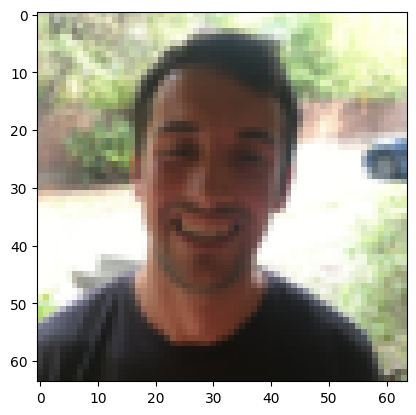

In [85]:
index = 4
plt.imshow(x_train[index]) #display sample training image
plt.show()

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [87]:
class HappyCNN(nn.Module):
    def __init__(self, input_channels = 3):
        super(HappyCNN, self).__init__()
        self.conv = nn.Conv2d(input_channels, 32, kernel_size=7, stride=1, padding=3)
        self.bn = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 32 * 32, 1)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = F.sigmoid(x)
        return x

In [88]:
model = HappyCNN()

In [89]:
# Summary of model

from torchsummary import summary

summary(model, (3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 64, 64]          4,736
├─BatchNorm2d: 1-2                       [-1, 32, 64, 64]          64
├─ReLU: 1-3                              [-1, 32, 64, 64]          --
├─MaxPool2d: 1-4                         [-1, 32, 32, 32]          --
├─Flatten: 1-5                           [-1, 32768]               --
├─Linear: 1-6                            [-1, 1]                   32,769
Total params: 37,569
Trainable params: 37,569
Non-trainable params: 0
Total mult-adds (M): 19.30
Input size (MB): 0.05
Forward/backward pass size (MB): 2.00
Params size (MB): 0.14
Estimated Total Size (MB): 2.19


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 64, 64]          4,736
├─BatchNorm2d: 1-2                       [-1, 32, 64, 64]          64
├─ReLU: 1-3                              [-1, 32, 64, 64]          --
├─MaxPool2d: 1-4                         [-1, 32, 32, 32]          --
├─Flatten: 1-5                           [-1, 32768]               --
├─Linear: 1-6                            [-1, 1]                   32,769
Total params: 37,569
Trainable params: 37,569
Non-trainable params: 0
Total mult-adds (M): 19.30
Input size (MB): 0.05
Forward/backward pass size (MB): 2.00
Params size (MB): 0.14
Estimated Total Size (MB): 2.19

In [90]:
batch_size = 32
epochs = 10

In [91]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [92]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

In [93]:
x_train.shape, y_train.shape
x_train = x_train.permute(0, 3, 1, 2)

In [94]:
for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch+1}, Loss: {loss.item():.3f}')


Epoch: 1, Loss: 0.769
Epoch: 2, Loss: 0.228
Epoch: 3, Loss: 0.212
Epoch: 4, Loss: 0.261
Epoch: 5, Loss: 0.281
Epoch: 6, Loss: 0.236
Epoch: 7, Loss: 0.033
Epoch: 8, Loss: 0.131
Epoch: 9, Loss: 0.048
Epoch: 10, Loss: 0.018


In [95]:
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

x_test.shape, y_test.shape

(torch.Size([150, 64, 64, 3]), torch.Size([150, 1]))

In [96]:
x_test = x_test.permute(0, 3, 1, 2)

In [97]:

with torch.no_grad():
    y_pred = model(x_test)
    y_pred = y_pred.round()
    acc = y_pred.eq(y_test).sum() / float(y_test.shape[0])
    print(f'Accuracy: {acc:.3f}')

Accuracy: 0.967


In [98]:
# Test on custom image

from PIL import Image
import torchvision.transforms as transforms

img = Image.open('datasets/custom-happy.jpg')
img = img.resize((64, 64))
img = transforms.ToTensor()(img)
img = img.unsqueeze(0)

with torch.no_grad():
    y_pred = model(img)
    y_pred = y_pred.round()
    print(f'The person is {"happy" if y_pred.item() == 1 else "not happy"}')

The person is happy


In [99]:
torch.save(model.state_dict(), 'model/happy-cnn.pth')